In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [4]:

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform, loguniform

In [5]:
from lifelines import KaplanMeierFitter

In [6]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.meta import Stacking
from sksurv.linear_model import CoxPHSurvivalAnalysis

## Import dataset

In [7]:
# Import dataset
df = pd.read_csv('dataset_da_2017.csv', encoding='utf-8')
print(df.head())

   Patient ID  Year of diagnosis     Sex  Age   Race Median household income  \
0        3614               2017  Female   74  White               ≥ $75,000   
1        4135               2017  Female   78  White               ≥ $75,000   
2        4432               2017  Female   69  White               ≥ $75,000   
3        7922               2017  Female   79  White               ≥ $75,000   
4       66852               2017  Female   81  White               ≥ $75,000   

      Marital status at diagnosis    Grade Combined Summary Stage Stage Group  \
0  Married (including common law)      III                Distant          IV   
1                         Widowed  Unknown                Distant          IV   
2                        Divorced  Unknown                Distant          IV   
3                        Divorced       II               Regional          II   
4  Married (including common law)      III               Regional         III   

   ... Surgery Radiation Chemoth

In [8]:
# Drop some unuseful columns
columns_to_drop = ['Patient ID', 'Year of diagnosis', 'Survival months flag']
df = df.drop(columns=columns_to_drop)
print(df.head())
print(df.shape)

      Sex  Age   Race Median household income     Marital status at diagnosis  \
0  Female   74  White               ≥ $75,000  Married (including common law)   
1  Female   78  White               ≥ $75,000                         Widowed   
2  Female   69  White               ≥ $75,000                        Divorced   
3  Female   79  White               ≥ $75,000                        Divorced   
4  Female   81  White               ≥ $75,000  Married (including common law)   

     Grade Combined Summary Stage Stage Group Tumor Size Surgery Radiation  \
0      III                Distant          IV         50      No   Unknown   
1  Unknown                Distant          IV         56      No   Unknown   
2  Unknown                Distant          IV         66      No   Unknown   
3       II               Regional          II         23     Yes   Unknown   
4      III               Regional         III         68      No       Yes   

  Chemotherapy Mets at DX-bone Mets at DX-br

In [9]:
# Replace the unknown values with NaNs
df.replace("Unknown", np.nan, inplace=True)
print(df.head())

      Sex  Age   Race Median household income     Marital status at diagnosis  \
0  Female   74  White               ≥ $75,000  Married (including common law)   
1  Female   78  White               ≥ $75,000                         Widowed   
2  Female   69  White               ≥ $75,000                        Divorced   
3  Female   79  White               ≥ $75,000                        Divorced   
4  Female   81  White               ≥ $75,000  Married (including common law)   

  Grade Combined Summary Stage Stage Group Tumor Size Surgery Radiation  \
0   III                Distant          IV         50      No       NaN   
1   NaN                Distant          IV         56      No       NaN   
2   NaN                Distant          IV         66      No       NaN   
3    II               Regional          II         23     Yes       NaN   
4   III               Regional         III         68      No       Yes   

  Chemotherapy Mets at DX-bone Mets at DX-brain Mets at DX-liv

## Calculate the percentage of missing values

In [10]:
# Calculate the percentage of missing values ​​for each column
missing_percentage = df.isnull().sum() / len(df)
# Sort the percentage of missing values
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
print(missing_percentage_sorted)

Radiation                      0.571482
Grade                          0.508077
Tumor Size                     0.131180
Marital status at diagnosis    0.044407
Mets at DX-lung                0.016527
Mets at DX-liver               0.015061
Mets at DX-brain               0.014687
Mets at DX-bone                0.013135
Combined Summary Stage         0.005087
Race                           0.003708
Sex                            0.000000
Survival months                0.000000
Surgery                        0.000000
Chemotherapy                   0.000000
Age                            0.000000
Stage Group                    0.000000
Median household income        0.000000
Vital status                   0.000000
dtype: float64


In [11]:
# Check the type of variables
print(df.dtypes)

Sex                            object
Age                             int64
Race                           object
Median household income        object
Marital status at diagnosis    object
Grade                          object
Combined Summary Stage         object
Stage Group                    object
Tumor Size                     object
Surgery                        object
Radiation                      object
Chemotherapy                   object
Mets at DX-bone                object
Mets at DX-brain               object
Mets at DX-liver               object
Mets at DX-lung                object
Survival months                 int64
Vital status                   object
dtype: object


## Split the dataset into train and test set

In [12]:
# Define X and y
X = df.drop(['Survival months', 'Vital status'], axis=1)
y_surv = df['Survival months']
y_vital = df['Vital status']
# Split data for 70% train and 30% test
x_train, x_test, y_surv_train, y_surv_test, y_vital_train, y_vital_test = train_test_split(
    X, y_surv, y_vital, test_size=0.3, random_state=42, stratify=y_vital)

## Label encoding: Median household income, Grade, Stage Group, Combined Summary Stage

In [13]:
# Create mapping dictionaries
income_mapping = {'< $35,000': 0, '$35,000 - $39,999': 1, '$40,000 - $44,999': 2, '$45,000 - $49,999': 3, '$50,000 - $54,999': 4,
                  '$55,000 - $59,999': 5, '$60,000 - $64,999': 6, '$65,000 - $69,999': 7, '$70,000 - $74,999': 8, '≥ $75,000': 9}
grade_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
stage_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
summary_stage_mapping = {'Localized': 0, 'Regional': 1, 'Distant': 2}

# Encode the ordinal variables
x_train['Median household income'] = x_train['Median household income'].map(income_mapping)
x_test['Median household income'] = x_test['Median household income'].map(income_mapping)

x_train['Grade'] = x_train['Grade'].map(grade_mapping)
x_test['Grade'] = x_test['Grade'].map(grade_mapping)

x_train['Stage Group'] = x_train['Stage Group'].map(stage_mapping)
x_test['Stage Group'] = x_test['Stage Group'].map(stage_mapping)

x_train['Combined Summary Stage'] = x_train['Combined Summary Stage'].map(summary_stage_mapping)
x_test['Combined Summary Stage'] = x_test['Combined Summary Stage'].map(summary_stage_mapping)

In [14]:
print(x_train.dtypes)
print(x_train.head())

Sex                             object
Age                              int64
Race                            object
Median household income          int64
Marital status at diagnosis     object
Grade                          float64
Combined Summary Stage         float64
Stage Group                      int64
Tumor Size                      object
Surgery                         object
Radiation                       object
Chemotherapy                    object
Mets at DX-bone                 object
Mets at DX-brain                object
Mets at DX-liver                object
Mets at DX-lung                 object
dtype: object
          Sex  Age   Race  Median household income  \
6636     Male   85  White                        8   
24979  Female   58  White                        3   
12378  Female   75  White                        8   
15263  Female   70  White                        9   
21547    Male   74  White                        5   

          Marital status at diagnosis

## One-hot encoding

In [15]:
# Nominal variables
nominal_vars = ["Sex", "Race", "Marital status at diagnosis", "Surgery", "Radiation",
                "Chemotherapy", "Mets at DX-bone", "Mets at DX-brain", "Mets at DX-lung",
                "Mets at DX-liver"]

# Perform One-Hot encoding on nominal variables
x_train = pd.get_dummies(x_train, columns=nominal_vars)
x_test = pd.get_dummies(x_test, columns=nominal_vars)

In [16]:
print(x_train.dtypes)
print(x_train.head())

Age                                                             int64
Median household income                                         int64
Grade                                                         float64
Combined Summary Stage                                        float64
Stage Group                                                     int64
Tumor Size                                                     object
Sex_Female                                                      uint8
Sex_Male                                                        uint8
Race_American Indian/Alaska Native                              uint8
Race_Asian or Pacific Islander                                  uint8
Race_Black                                                      uint8
Race_White                                                      uint8
Marital status at diagnosis_Divorced                            uint8
Marital status at diagnosis_Married (including common law)      uint8
Marital status at di

## Convert "Tumor Size" into a numeric variable

In [17]:
x_train["Tumor Size"] = pd.to_numeric(x_train["Tumor Size"], errors="coerce")
x_test["Tumor Size"] = pd.to_numeric(x_test["Tumor Size"], errors="coerce")
print(x_train.dtypes)
print(x_train.head())

Age                                                             int64
Median household income                                         int64
Grade                                                         float64
Combined Summary Stage                                        float64
Stage Group                                                     int64
Tumor Size                                                    float64
Sex_Female                                                      uint8
Sex_Male                                                        uint8
Race_American Indian/Alaska Native                              uint8
Race_Asian or Pacific Islander                                  uint8
Race_Black                                                      uint8
Race_White                                                      uint8
Marital status at diagnosis_Divorced                            uint8
Marital status at diagnosis_Married (including common law)      uint8
Marital status at di

## Imputation with KNN

In [18]:
# Save the column names and indexes before imputation
columns = x_train.columns.tolist()
train_index = x_train.index
test_index = x_test.index

In [22]:
%%time
# Initialize the KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)  
# Fit the imputer on the training data and transform it
x_train_imputed = imputer.fit_transform(x_train)
# Transform the test data
x_test_imputed = imputer.transform(x_test)

MemoryError: Unable to allocate 466. MiB for an array with shape (11949, 5117) and data type float64

In [20]:
# Check if there are still missing values in the dataset
print(np.isnan(x_train_imputed).sum())
print(np.isnan(x_test_imputed).sum())

NameError: name 'x_train_imputed' is not defined

In [ ]:
# Convert back to pandas dataframe
x_train_df = pd.DataFrame(x_train_imputed, columns=columns, index=train_index)
x_test_df = pd.DataFrame(x_test_imputed, columns=columns, index=test_index)
print(x_train_df.columns)
print(x_train_df.index)

Index(['Age', 'Median household income', 'Grade', 'Combined Summary Stage',
       'Stage Group', 'Tumor Size', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaska Native', 'Race_Asian or Pacific Islander',
       'Race_Black', 'Race_White', 'Marital status at diagnosis_Divorced',
       'Marital status at diagnosis_Married (including common law)',
       'Marital status at diagnosis_Separated',
       'Marital status at diagnosis_Single (never married)',
       'Marital status at diagnosis_Unmarried or Domestic Partner',
       'Marital status at diagnosis_Widowed', 'Surgery_No', 'Surgery_Yes',
       'Radiation_No', 'Radiation_Yes', 'Chemotherapy_No', 'Chemotherapy_Yes',
       'Mets at DX-bone_No', 'Mets at DX-bone_Yes', 'Mets at DX-brain_No',
       'Mets at DX-brain_Yes', 'Mets at DX-lung_No', 'Mets at DX-lung_Yes',
       'Mets at DX-liver_No', 'Mets at DX-liver_Yes'],
      dtype='object')
Index([ 6636, 24979, 12378, 15263, 21547, 17873, 28370,  2227, 12896, 11652,
   

In [ ]:
# Convert into integer
cols_to_convert = ['Age', 'Median household income', 'Grade', 'Stage Group', 'Combined Summary Stage']
for col in cols_to_convert:
    x_train_df[col] = x_train_df[col].astype(int)
    x_test_df[col] = x_test_df[col].astype(int)

In [ ]:
x_train_df.head()

,Age,Median household income,Grade,Combined Summary Stage,Stage Group,Tumor Size,Sex_Female,Sex_Male,Race_American Indian/Alaska Native,Race_Asian or Pacific Islander,...,Chemotherapy_No,Chemotherapy_Yes,Mets at DX-bone_No,Mets at DX-bone_Yes,Mets at DX-brain_No,Mets at DX-brain_Yes,Mets at DX-lung_No,Mets at DX-lung_Yes,Mets at DX-liver_No,Mets at DX-liver_Yes
6636,85,8,1,0,0,40.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
24979,58,3,2,2,3,35.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
12378,75,8,1,0,0,35.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
15263,70,9,1,0,0,9.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
21547,74,5,1,2,3,77.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Normalisation

In [ ]:
#  Normalisation using StandardScaler
scaler = StandardScaler()
columns_to_scale = ['Age', 'Tumor Size']
x_train_df[columns_to_scale] = scaler.fit_transform(x_train_df[columns_to_scale])
x_test_df[columns_to_scale] = scaler.transform(x_test_df[columns_to_scale])

In [ ]:
x_train_df.head()

,Age,Median household income,Grade,Combined Summary Stage,Stage Group,Tumor Size,Sex_Female,Sex_Male,Race_American Indian/Alaska Native,Race_Asian or Pacific Islander,...,Chemotherapy_No,Chemotherapy_Yes,Mets at DX-bone_No,Mets at DX-bone_Yes,Mets at DX-brain_No,Mets at DX-brain_Yes,Mets at DX-lung_No,Mets at DX-lung_Yes,Mets at DX-liver_No,Mets at DX-liver_Yes
6636,1.505685,8,1,0,0,-0.068547,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
24979,-1.192046,3,2,2,3,-0.242190,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
12378,0.506526,8,1,0,0,-0.242190,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
15263,0.006946,9,1,0,0,-1.145136,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
21547,0.406610,5,1,2,3,1.216414,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Response Classification

We split the response 'Survival months' into 3 categories: '≤6 months', '7-24 months', '＞24 months'.

In [27]:
# Split the response y_surv into 3 categories: '≤6 months', '7-24 months', '＞24 months' for classification models
bins = [0, 6, 24, float('inf')]
labels = ['≤6 months', '7-24 months', '＞24 months']
y_train_category = pd.cut(y_surv_train, bins=bins, labels=labels, include_lowest=True)
y_test_category = pd.cut(y_surv_test, bins=bins, labels=labels, include_lowest=True)
print(y_train_category)
print(y_test_category)
# Calculate the percentage of each category
category_proportions = y_train_category.value_counts(normalize=True)
print("Category Proportions:")
print(category_proportions)

6636     7-24 months
24979      ≤6 months
12378     ＞24 months
15263     ＞24 months
21547      ≤6 months
            ...     
25212     ＞24 months
34368     ＞24 months
9771      ＞24 months
29939      ≤6 months
27336     ＞24 months
Name: Survival months, Length: 24354, dtype: category
Categories (3, object): ['≤6 months' < '7-24 months' < '＞24 months']
21203    7-24 months
33348      ≤6 months
22735     ＞24 months
28683      ≤6 months
10206      ≤6 months
            ...     
25401    7-24 months
4337      ＞24 months
2415      ＞24 months
24014    7-24 months
22527      ≤6 months
Name: Survival months, Length: 10438, dtype: category
Categories (3, object): ['≤6 months' < '7-24 months' < '＞24 months']
Category Proportions:
Survival months
＞24 months     0.408516
≤6 months      0.341546
7-24 months    0.249938
Name: proportion, dtype: float64


## Feature selection

In [ ]:
# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_df, y_train_category)

# Obtain the importance of features
feature_importances_classifier = rf_classifier.feature_importances_
important_features_classifier = pd.Series(feature_importances_classifier, index=x_train_df.columns)
important_features_classifier_sorted = important_features_classifier.sort_values(ascending=False)

# Print features with importance > 0.02
print("Features with Importance > 0.02 (Classifier):")
for feature, importance in important_features_classifier_sorted.items():
    if importance > 0.02:
        print(f"{feature}: {importance:.4f}")

Features with Importance > 0.02 (Classifier):
Tumor Size: 0.2242
Age: 0.1774
Median household income: 0.1052
Stage Group: 0.0610
Combined Summary Stage: 0.0476
Grade: 0.0427
Surgery_No: 0.0321
Radiation_Yes: 0.0308
Chemotherapy_No: 0.0297
Chemotherapy_Yes: 0.0261
Surgery_Yes: 0.0253


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(x_train_df, y_surv_train)

# Obtain the importance of features
feature_importances_regressor = rf_regressor.feature_importances_
important_features_regressor = pd.Series(feature_importances_regressor, index=x_train_df.columns)
important_features_regressor_sorted = important_features_regressor.sort_values(ascending=False)

# Print features with importance > 0.02
print("Features with Importance > 0.02 (Regressor):")
for feature, importance in important_features_regressor_sorted.items():
    if importance > 0.02:
        print(f"{feature}: {importance:.4f}")

Features with Importance > 0.02 (Regressor):
Stage Group: 0.2323
Tumor Size: 0.1802
Age: 0.1394
Median household income: 0.0745
Radiation_Yes: 0.0382
Surgery_No: 0.0357
Surgery_Yes: 0.0328
Grade: 0.0316
Combined Summary Stage: 0.0306
Chemotherapy_No: 0.0288
Chemotherapy_Yes: 0.0277


## Regression models

In [21]:
# Reset indices to ensure consistency
x_train_df = x_train_df.reset_index(drop=True)
x_test_df = x_test_df.reset_index(drop=True)
y_surv_train = y_surv_train.reset_index(drop=True)
y_surv_test = y_surv_test.reset_index(drop=True)
y_vital_train = y_vital_train.reset_index(drop=True)
y_vital_test = y_vital_test.reset_index(drop=True)

# Combine features and target variables
train_data_new = pd.concat([x_train_df, y_surv_train, y_vital_train], axis=1)
test_data_new = pd.concat([x_test_df, y_surv_test, y_vital_test], axis=1)

# Map 'Alive' to 0 and 'Dead' to 1
train_data_new['Vital status'] = train_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})
test_data_new['Vital status'] = test_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})

# Function to convert DataFrame to structured array for scikit-survival
def df_to_structured(df, event_col, time_col):
    return np.array([(e, t) for e, t in zip(df[event_col], df[time_col])], dtype=[('event', bool), ('time', np.float64)])

# Convert training and testing data
y_train_structured = df_to_structured(train_data_new, 'Vital status', 'Survival months')
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

NameError: name 'x_train_df' is not defined

### 1. Cox Proportional Hazards Model

####  Mean (lifelines：without inbuilt gridsearch method to perform hyperparameter tuning) 

       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       14.423055
1                    2             1                       23.193215
2                   31             1                       34.820741
3                    6             0                       15.263463
4                    4             1                       29.817649
...                ...           ...                             ...
10433               12             1                       20.667108
10434               28             1                       33.128178
10435               41             0                        5.982261
10436               10             1                       18.659385
10437                1             1                        7.096124

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Mean Prediction: 13.126123235141703
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.648021200

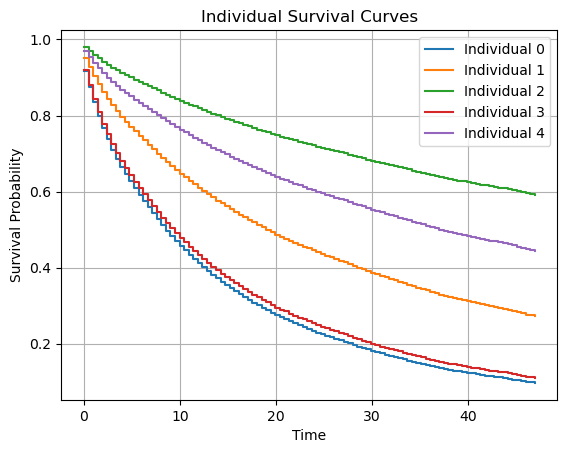

CPU times: total: 641 ms
Wall time: 386 ms


In [29]:
%%time
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.utils import concordance_index

# Train the Cox Proportional Hazards model with L2 regularization
coxph = CoxPHFitter(penalizer=0.01)
coxph.fit(train_data_new, duration_col='Survival months', event_col='Vital status')

# Define a function to calculate the mean survival time from the survival function
#def mean_survival_time(survival_function):
    #return np.trapz(survival_function.values, survival_function.index)

# Predict the mean survival time for each individual in the test set
#predicted_means = test_data_survival_curves.apply(mean_survival_time, axis=0)
predicted_means  = coxph.predict_expectation(test_data_new.drop(['Vital status', 'Survival months'], axis=1))

# Convert the predictions to a DataFrame for further processing
predicted_means = pd.DataFrame(predicted_means, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results = pd.concat([test_data_new.reset_index(drop=True), predicted_means.reset_index(drop=True)], axis=1)
print(results[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']] )

# Calculate RMSE for Mean Predictions
mse_mean = mean_squared_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
rmse_mean = np.sqrt(mse_mean)
print("Root Mean Squared Error (RMSE) with Mean Prediction:", rmse_mean)

# Calculate RRMSE
mean_observed = np.mean(results['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Estimate the survival function for each individual in the test set
test_data_survival_curves = coxph.predict_survival_function(test_data_new, times=np.linspace(0, max(y_surv_train), 100))

# Visualize the survival curves
for i in range(min(5, len(test_data_survival_curves.columns))):  # Plot survival curves for the first 5 individuals
    plt.step(test_data_survival_curves.index, test_data_survival_curves.iloc[:, i], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves')
plt.legend()
plt.grid(True)
plt.show()

#### Median

[ 9. 20. 47. ...  3. 13.  4.]
       Survival months  Vital status  Predicted Survival Time (Median)
0                   19             1                               9.0
1                    2             1                              20.0
2                   31             1                              47.0
3                    6             0                               9.0
4                    4             1                              32.0
...                ...           ...                               ...
10433               12             1                              17.0
10434               28             1                              47.0
10435               41             0                               3.0
10436               10             1                              13.0
10437                1             1                               4.0

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Median Prediction: 14.992154811178843
Root Relative Mean

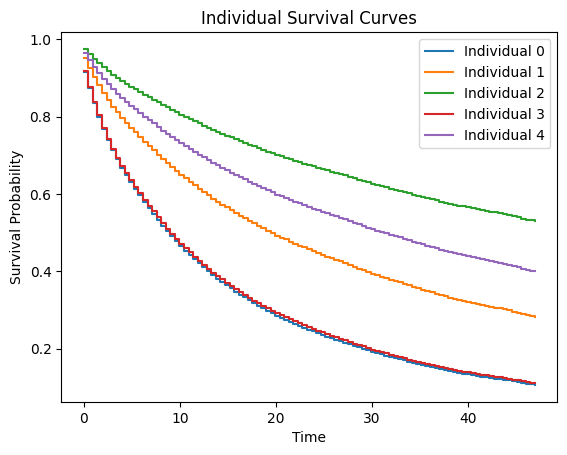

CPU times: total: 1.19 s
Wall time: 2.67 s


In [168]:
%%time

# Train the Cox Proportional Hazards model with L2 regularization
coxph = CoxPHFitter(penalizer=0.1)
coxph.fit(train_data_new, duration_col='Survival months', event_col='Vital status')

# Predict the median survival time for each individual in the test set
predicted_medians = coxph.predict_median(test_data_new.drop(['Vital status', 'Survival months'], axis=1))

predicted_medians = np.where(np.isinf(predicted_medians), 47, predicted_medians)
print(predicted_medians)

# Convert the predictions to a DataFrame for further processing
predicted_medians = pd.DataFrame(predicted_medians, columns=['Predicted Survival Time (Median)'])

# Merge the prediction results with the actual test data
results = pd.concat([test_data_new.reset_index(drop=True), predicted_medians.reset_index(drop=True)], axis=1)
print(results[['Survival months', 'Vital status', 'Predicted Survival Time (Median)']] )

# Calculate RMSE for Median Predictions
mse_mean = mean_squared_error(results['Survival months'], results['Predicted Survival Time (Median)'])
rmse_mean = np.sqrt(mse_mean)
print("Root Mean Squared Error (RMSE) with Median Prediction:", rmse_mean)

# Calculate RRMSE
mean_observed = np.mean(results['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Median Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results['Survival months'], results['Predicted Survival Time (Median)'])
print("Mean Absolute Error (MAE) with Median Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Estimate the survival function for each individual in the test set
test_data_survival_curves = coxph.predict_survival_function(test_data_new, times=np.linspace(0, max(y_surv_train), 100))

# Visualize the survival curves
for i in range(min(5, len(test_data_survival_curves.columns))):  # Plot survival curves for the first 5 individuals
    plt.step(test_data_survival_curves.index, test_data_survival_curves.iloc[:, i], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves')
plt.legend()
plt.show()

#### Hyperparameter tuning

Penalizer: 0.0001, Mean RMSE: 13.132167000032453
Penalizer: 0.000774263682681127, Mean RMSE: 13.130339580351901
Penalizer: 0.005994842503189409, Mean RMSE: 13.120927310581996
Penalizer: 0.046415888336127774, Mean RMSE: 13.083556101348393
Penalizer: 0.3593813663804626, Mean RMSE: 13.021444265759408
Penalizer: 2.782559402207126, Mean RMSE: 14.087959211048025
Penalizer: 21.54434690031882, Mean RMSE: 16.247330827276205
Penalizer: 166.81005372000558, Mean RMSE: 16.962397242949912
Penalizer: 1291.5496650148827, Mean RMSE: 17.071647106761155
Penalizer: 10000.0, Mean RMSE: 17.08608152385159
Best Penalizer: 0.3593813663804626, Best Mean RMSE: 13.021444265759408
       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       15.569164
1                    2             1                       22.890884
2                   31             1                       30.832365
3                    6             0                       14.9

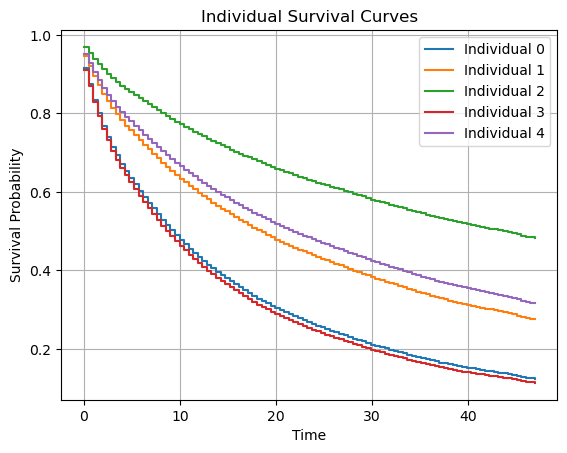

In [30]:
# Define a range of penalizer values to try
penalizer_values = np.logspace(-4, 4, 10)  # Creates an array of values from 10^-4 to 10^4

# Function to perform cross-validation and evaluate RMSE
def cross_validate_coxph(penalizer, train_data, n_splits=5):
    kf = KFold(n_splits=n_splits)
    rmses = []
    
    for train_index, val_index in kf.split(train_data):
        train_split = train_data.iloc[train_index]
        val_split = train_data.iloc[val_index]
        
        coxph = CoxPHFitter(penalizer=penalizer)
        coxph.fit(train_split, duration_col='Survival months', event_col='Vital status')
        
        predicted_means = coxph.predict_expectation(val_split.drop(['Vital status', 'Survival months'], axis=1))
        
        mse_mean = mean_squared_error(val_split['Survival months'], predicted_means)
        rmse_mean = np.sqrt(mse_mean)
        rmses.append(rmse_mean)
    
    return np.mean(rmses)

# Perform cross-validation for each penalizer value and store results
results = []

for penalizer in penalizer_values:
    mean_rmse = cross_validate_coxph(penalizer, train_data_new)
    results.append((penalizer, mean_rmse))
    print(f"Penalizer: {penalizer}, Mean RMSE: {mean_rmse}")

# Find the penalizer value with the lowest RMSE
best_penalizer, best_rmse = min(results, key=lambda x: x[1])
print(f"Best Penalizer: {best_penalizer}, Best Mean RMSE: {best_rmse}")

# Train the Cox Proportional Hazards model with the best penalizer
coxph_final = CoxPHFitter(penalizer=best_penalizer)
coxph_final.fit(train_data_new, duration_col='Survival months', event_col='Vital status')

# Predict the mean survival time for each individual in the test set
predicted_means = coxph_final.predict_expectation(test_data_new.drop(['Vital status', 'Survival months'], axis=1))

# Convert the predictions to a DataFrame for further processing
predicted_means = pd.DataFrame(predicted_means, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results = pd.concat([test_data_new.reset_index(drop=True), predicted_means.reset_index(drop=True)], axis=1)
print(results[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean = mean_squared_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
rmse_mean = np.sqrt(mse_mean)
print("Root Mean Squared Error (RMSE) with Mean Prediction:", rmse_mean)

# Calculate RRMSE
mean_observed = np.mean(results['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = coxph_final.score(test_data_new, scoring_method="concordance_index")
print("Concordance Index (C-index) of testing set:", c_index)

# Estimate the survival function for each individual in the test set
test_data_survival_curves = coxph_final.predict_survival_function(test_data_new, times=np.linspace(0, max(y_surv_train), 100))

# Visualize the survival curves
for i in range(min(5, len(test_data_survival_curves.columns))):  # Plot survival curves for the first 5 individuals
    plt.step(test_data_survival_curves.index, test_data_survival_curves.iloc[:, i], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves')
plt.legend()
plt.grid(True)
plt.show()

### 2. Random Survival Forest

#### Mean

       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       20.710437
1                    2             1                       20.977108
2                   31             1                       37.419136
3                    6             0                       16.330637
4                    4             1                       22.744550
...                ...           ...                             ...
10433               12             1                       20.763235
10434               28             1                       28.336224
10435               41             0                        5.163056
10436               10             1                       21.560703
10437                1             1                        4.911282

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 13.007974836634569
Root Relative Mean Squared Error (RRMSE) with Mean 

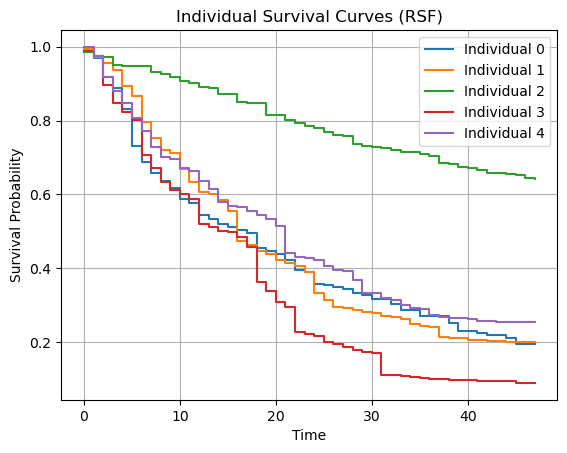

CPU times: total: 5min 4s
Wall time: 1min 48s


In [31]:
%%time

# Initialize and train the Random Survival Forest model
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)
rsf.fit(x_train_df, y_train_structured)

# Predict survival functions for the test set
test_surv_curves = rsf.predict_survival_function(x_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf = mean_survival_time_rsfs(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_rsf, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_rsf[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf = mean_squared_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
rmse_mean_rsf = np.sqrt(mse_mean_rsf)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_rsf)

# Calculate RRMSE
mean_observed = np.mean(results_rsf['Survival months'])
rrmse_mean = rmse_mean_rsf / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.grid(True)
plt.show()

#### Median

       Survival months  Vital status  Predicted Survival Time (Median)
0                   19             1                              19.0
1                    2             1                              16.0
2                   31             1                              47.0
3                    6             0                              12.0
4                    4             1                              18.0
...                ...           ...                               ...
10433               12             1                              15.0
10434               28             1                              30.0
10435               41             0                               1.0
10436               10             1                              20.0
10437                1             1                               2.0

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Median Prediction: 14.757917519986663
Root Relative Mean Square

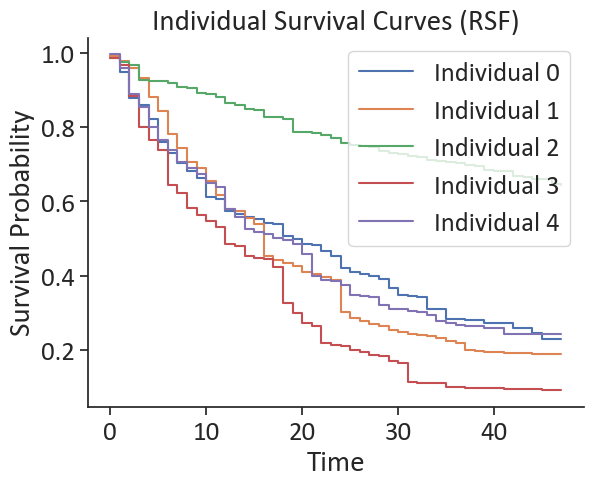

CPU times: total: 54 s
Wall time: 1min 38s


In [514]:
%%time

# Initialize and train the Random Survival Forest model
rsf = RandomSurvivalForest(random_state=42)
rsf.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Predict survival functions for the test set
test_surv_curves = rsf.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Define a function to calculate the median survival time from the survival function
def median_survival_time_rsfs(surv_funcs):
    median_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        if any(survival_probs <= 0.5):
            median_time = times[survival_probs <= 0.5][0]
        else:
            median_time = times[-1]  # If never reaches 0.5, return the maximum time value
        median_times.append(median_time)
    return np.array(median_times)

predicted_medians_rsf = median_survival_time_rsfs(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_medians_df = pd.DataFrame(predicted_medians_rsf, columns=['Predicted Survival Time (Median)'])

# Merge the prediction results with the actual test data
results_rsf = pd.concat([test_data_new.reset_index(drop=True), predicted_medians_df.reset_index(drop=True)], axis=1)
print(results_rsf[['Survival months', 'Vital status', 'Predicted Survival Time (Median)']])

# Calculate RMSE for Median Predictions
mse_median_rsf = mean_squared_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Median)'])
rmse_median_rsf = np.sqrt(mse_median_rsf)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Median Prediction:", rmse_median_rsf)

# Calculate RRMSE
mean_observed = np.mean(results_rsf['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Median Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Median)'])
print("Mean Absolute Error (MAE) with Median Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.show()

#### Hyparameter tuning

In [48]:
%%time
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}

# Initialize RandomSurvivalForest
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Extract the best parameters
best_params = grid_search.best_params_


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
CPU times: total: 1min 45s
Wall time: 5min 47s


       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       20.130670
1                    2             1                       22.359099
2                   31             1                       37.264445
3                    6             0                       16.988246
4                    4             1                       21.825695
...                ...           ...                             ...
10433               12             1                       19.371331
10434               28             1                       27.735714
10435               41             0                        6.978365
10436               10             1                       20.964374
10437                1             1                        6.067790

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Optimized Random Survival Forest Mean Prediction: 12.981092876569845
Root Relative Mean Squared Error (RRMSE) 

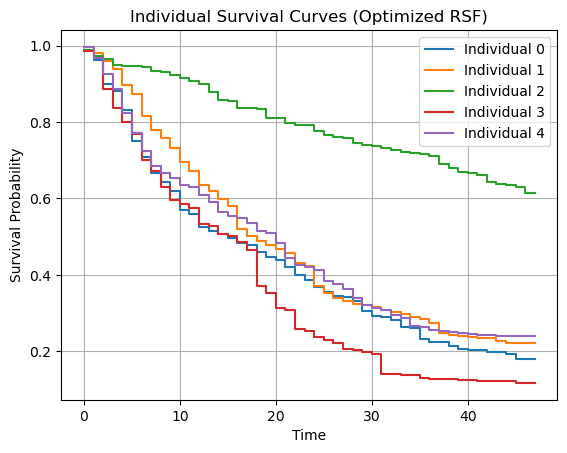

In [49]:
# Initialize the Random Survival Forest with the best parameters
rsf_best = RandomSurvivalForest(n_estimators=best_params['n_estimators'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                n_jobs=-1, random_state=42)

# Train the final model
rsf_best.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Convert test data
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

# Predict survival functions for the test set
test_surv_curves_best = rsf_best.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf_best = mean_survival_time_rsfs(test_surv_curves_best)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_best = pd.DataFrame(predicted_means_rsf_best, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf_best = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_best.reset_index(drop=True)], axis=1)
print(results_rsf_best[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf_best = mean_squared_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
rmse_mean_rsf_best = np.sqrt(mse_mean_rsf_best)
print("Root Mean Squared Error (RMSE) with Optimized Random Survival Forest Mean Prediction:", rmse_mean_rsf_best)

# Calculate RRMSE
mean_observed = np.mean(results_rsf_best['Survival months'])
rrmse_mean = rmse_mean_rsf_best / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf_best.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves_best))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves_best[i].x, test_surv_curves_best[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Optimized RSF)')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
%%time
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [0.1, 0.5, 0.9],
    'max_depth': [5, 10, 15]
}

# Initialize RandomSurvivalForest
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Extract the best parameters
best_params = grid_search.best_params_


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

Best Parameters: {'max_depth': 5, 'max_features': 0.1, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
CPU times: total: 11.3 s
Wall time: 1h 51min 38s


       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       17.374693
1                    2             1                       23.587871
2                   31             1                       34.267898
3                    6             0                       14.955319
4                    4             1                       16.266947
...                ...           ...                             ...
10433               12             1                       21.902570
10434               28             1                       23.967126
10435               41             0                       12.429123
10436               10             1                       16.806968
10437                1             1                       14.196824

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Optimized Random Survival Forest Mean Prediction: 13.44873482512025
Root Relative Mean Squared Error (RRMSE) w

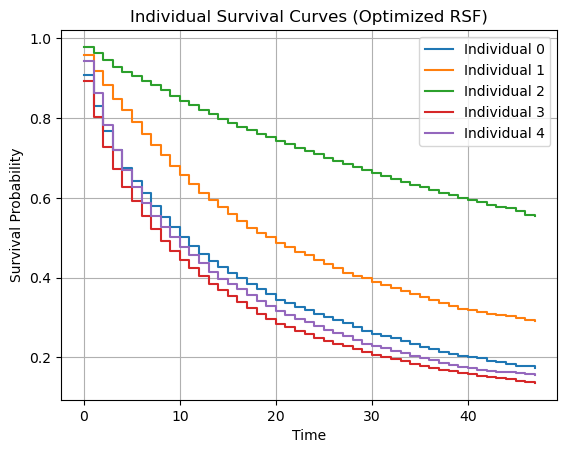

In [37]:
# Initialize the Random Survival Forest with the best parameters
rsf_best = RandomSurvivalForest(n_estimators=best_params['n_estimators'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                max_features=best_params['max_features'],
                                max_depth=best_params['max_depth'],
                                n_jobs=-1, random_state=42)

# Train the final model
rsf_best.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Convert test data
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

# Predict survival functions for the test set
test_surv_curves_best = rsf_best.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf_best = mean_survival_time_rsfs(test_surv_curves_best)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_best = pd.DataFrame(predicted_means_rsf_best, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf_best = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_best.reset_index(drop=True)], axis=1)
print(results_rsf_best[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf_best = mean_squared_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
rmse_mean_rsf_best = np.sqrt(mse_mean_rsf_best)
print("Root Mean Squared Error (RMSE) with Optimized Random Survival Forest Mean Prediction:", rmse_mean_rsf_best)

# Calculate RRMSE
mean_observed = np.mean(results_rsf_best['Survival months'])
rrmse_mean = rmse_mean_rsf_best / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf_best.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves_best))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves_best[i].x, test_surv_curves_best[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Optimized RSF)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [0.1, 0.5, 0.9],
    'max_depth': [5, 10, 15]
}

# Initialize RandomSurvivalForest
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Extract the best parameters
best_params = grid_search.best_params_

In [ ]:

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

# Extract the best parameters
best_params = random_search.best_params_

# Initialize the Random Survival Forest with the best parameters
rsf_best = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                 min_samples_split=best_params['min_samples_split'],
                                 min_samples_leaf=best_params['min_samples_leaf'],
                                 max_features=best_params['max_features'],
                                 max_depth=best_params['max_depth'],
                                 n_jobs=-1, random_state=42)

# Train the final model
rsf_best.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Predict survival functions for the test set
test_surv_curves_best = rsf_best.predict(test_data_new.drop(['Vital status', 'Survival months'], axis=1))

# Convert the predictions to a DataFrame for further processing
predicted_means_df_best = pd.DataFrame(test_surv_curves_best, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf_best = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_best.reset_index(drop=True)], axis=1)
print(results_rsf_best[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf_best = mean_squared_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
rmse_mean_rsf_best = np.sqrt(mse_mean_rsf_best)
print("Root Mean Squared Error (RMSE) with Optimized Random Survival Forest Mean Prediction:", rmse_mean_rsf_best)

# Calculate RRMSE
mean_observed = np.mean(results_rsf_best['Survival months'])
rrmse_mean = rmse_mean_rsf_best / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf_best.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves_best))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves_best[i].x, test_surv_curves_best[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Optimized RSF)')
plt.legend()
plt.show()


##### testing

In [73]:
%%time
from scipy.stats import randint, uniform

# Define parameter distribution for RandomSurvivalForest
param_dist = {
    'n_estimators': randint(50, 500),  # Number of trees
    'max_features': uniform(0.1, 0.9),  # Max features per split
    'min_samples_split': randint(2, 20),  # Min samples to split a node
    'min_samples_leaf': randint(2, 20),  # Min samples required at each leaf node
    'max_depth': randint(2, 20) # Max depth of the trees
}

# Initialize Random Survival Forest model
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)

# Initialize Randomized Search
random_search = RandomizedSearchCV(
    estimator=rsf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    scoring='neg_mean_squared_error',  # RMSE as the score
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search
random_search.fit(x_train_df, y_train_structured)


c:\Users\小敏\.conda\envs\PY37\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best hyperparameters: {'max_depth': 8, 'max_features': 0.8168886881742096, 'min_samples_leaf': 16, 'min_samples_split': 12, 'n_estimators': 121}
       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       20.528438
1                    2             1                       22.440761
2                   31             1                       39.717497
3                    6             0                       17.314747
4                    4             1                       25.031927
...                ...           ...                             ...
10433               12             1                       20.826469
10434               28             1                       28.661469
10435               41             0                        4.129078
10436               10             1                       20.464246
10437                1             1                        6.508616

[10438 rows x 3 columns]
R

NameError: name 'concordance_index_censored' is not defined

In [ ]:
# Best model
best_model = random_search.best_estimator_
print(f"Best hyperparameters: {random_search.best_params_}")

# Predict survival functions for the test set
test_surv_curves = best_model.predict_survival_function(x_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf = mean_survival_time_rsfs(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_rsf, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_rsf[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf = mean_squared_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
rmse_mean_rsf = np.sqrt(mse_mean_rsf)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_rsf)

# Calculate RRMSE
mean_observed = np.mean(results_rsf['Survival months'])
rrmse_mean = rmse_mean_rsf / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

In [75]:
# Calculate C-index
c_index = rsf.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.show()

NotFittedError: This RandomSurvivalForest instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

##### Works

In [72]:
%%time
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2', None],  # Consider different strategies for selecting max features
    'max_depth': [5, 10, 15]  # Consider different max depth values
}

# Initialize RandomSurvivalForest
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Extract the best parameters
best_params = grid_search.best_params_

# Initialize the Random Survival Forest with the best parameters
rsf_best = RandomSurvivalForest(n_estimators=best_params['n_estimators'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                n_jobs=-1, random_state=42)

# Train the final model
rsf_best.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Convert test data
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

# Predict survival functions for the test set
test_surv_curves_best = rsf_best.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf_best = mean_survival_time_rsfs(test_surv_curves_best)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_best = pd.DataFrame(predicted_means_rsf_best, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf_best = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_best.reset_index(drop=True)], axis=1)
print(results_rsf_best[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf_best = mean_squared_error(results_rsf_best['Survival months'], results_rsf_best['Predicted Survival Time (Mean)'])
rmse_mean_rsf_best = np.sqrt(mse_mean_rsf_best)
print("Root Mean Squared Error (RMSE) with Optimized Random Survival Forest Mean Prediction:", rmse_mean_rsf_best)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves_best))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves_best[i].x, test_surv_curves_best[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Optimized RSF)')
plt.legend()
plt.show()

KeyboardInterrupt: 

### 3. GradientBoostingSurvivalAnalysis

#### Mean

In [110]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# Initialize and train the Gradient Boosting Survival Analysis model
gbm = GradientBoostingSurvivalAnalysis(random_state=42)
gbm.fit(x_train_df, y_train_structured)


CPU times: total: 10min 12s
Wall time: 15min 32s


GradientBoostingSurvivalAnalysis(random_state=42)

In [46]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# Initialize and train the Gradient Boosting Survival Analysis model
gbm = GradientBoostingSurvivalAnalysis(learning_rate=0.1, n_estimators=200, min_samples_split=5, min_samples_leaf=5, random_state=42)
gbm.fit(x_train_df, y_train_structured)

CPU times: total: 23min 10s
Wall time: 23min 10s


GradientBoostingSurvivalAnalysis(min_samples_leaf=5, min_samples_split=5,
                                 n_estimators=200, random_state=42)

       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       20.367741
1                    2             1                       20.683204
2                   31             1                       36.384574
3                    6             0                       17.322434
4                    4             1                       26.791143
...                ...           ...                             ...
10433               12             1                       17.635718
10434               28             1                       25.215716
10435               41             0                        3.763500
10436               10             1                       19.977890
10437                1             1                        6.005758

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with GBM Mean Prediction: 12.840283131927622
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.63390

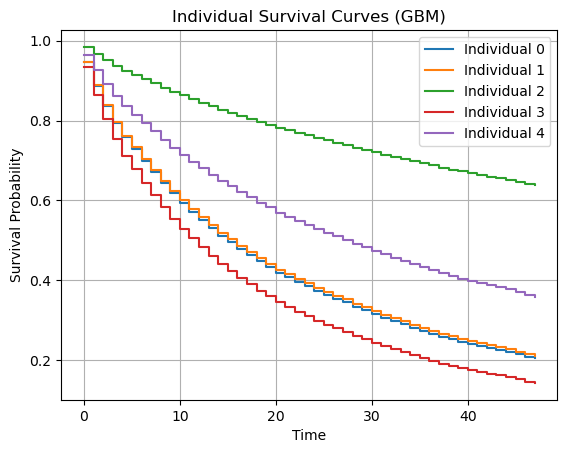

In [47]:
# Predict survival functions for the test set
test_surv_curves = gbm.predict_survival_function(x_test_df)

# Calculate mean survival time for each individual
def mean_survival_time_gbm(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_gbm = mean_survival_time_gbm(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_gbm, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_gbm = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_gbm[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_gbm = mean_squared_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
rmse_mean_gbm = np.sqrt(mse_mean_gbm)
print("Root Mean Squared Error (RMSE) with GBM Mean Prediction:", rmse_mean_gbm)

# Calculate RRMSE
mean_observed = np.mean(results_gbm['Survival months'])
rrmse_mean = rmse_mean_gbm / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
c_index = gbm.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (GBM)')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# Initialize and train the Gradient Boosting Survival Analysis model
gbm = GradientBoostingSurvivalAnalysis(learning_rate=0.01, n_estimators=100, min_samples_split=5, min_samples_leaf=5, random_state=42)
gbm.fit(x_train_df, y_train_structured)

CPU times: total: 11min 34s
Wall time: 11min 34s


GradientBoostingSurvivalAnalysis(learning_rate=0.01, min_samples_leaf=5,
                                 min_samples_split=5, random_state=42)

       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       19.926799
1                    2             1                       22.412441
2                   31             1                       29.417077
3                    6             0                       19.926799
4                    4             1                       19.497526
...                ...           ...                             ...
10433               12             1                       23.187199
10434               28             1                       23.577268
10435               41             0                       13.887999
10436               10             1                       19.926799
10437                1             1                       13.887999

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with GBM Mean Prediction: 14.171792501895903
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.69964

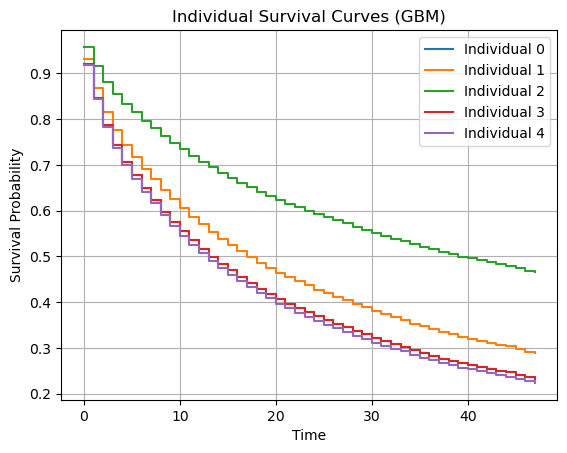

In [45]:
# Predict survival functions for the test set
test_surv_curves = gbm.predict_survival_function(x_test_df)

# Calculate mean survival time for each individual
def mean_survival_time_gbm(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_gbm = mean_survival_time_gbm(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_gbm, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_gbm = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_gbm[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_gbm = mean_squared_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
rmse_mean_gbm = np.sqrt(mse_mean_gbm)
print("Root Mean Squared Error (RMSE) with GBM Mean Prediction:", rmse_mean_gbm)

# Calculate RRMSE
mean_observed = np.mean(results_gbm['Survival months'])
rrmse_mean = rmse_mean_gbm / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
c_index = gbm.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (GBM)')
plt.legend()
plt.grid(True)
plt.show()

#### Median

In [1]:
%%time
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
gbsa.fit(x_train_df, y_train_structured)

# Predict survival functions for the test set
test_surv_curves = gbsa.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Define a function to calculate the median survival time from the survival function
def median_survival_time_rsfs(surv_funcs):
    median_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        if any(survival_probs <= 0.5):
            median_time = times[survival_probs <= 0.5][0]
        else:
            median_time = times[-1]  # If never reaches 0.5, return the maximum time value
        median_times.append(median_time)
    return np.array(median_times)

predicted_medians_gbsa = median_survival_time_gbsa(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_medians_df = pd.DataFrame(predicted_medians_gbsa, columns=['Predicted Survival Time (Median)'])

# Merge the prediction results with the actual test data
results_gbsa = pd.concat([test_data_new.reset_index(drop=True), predicted_medians_df.reset_index(drop=True)], axis=1)
print(results_gbsa[['Survival months', 'Vital status', 'Predicted Survival Time (Median)']])

# Calculate RMSE for Median Predictions
mse_median_gbsa = mean_squared_error(results_gbsa['Survival months'], results_gbsa['Predicted Survival Time (Median)'])
rmse_median_gbsa = np.sqrt(mse_median_gbsa)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Median Prediction:", rmse_median_gbsa)

# Calculate RRMSE
mean_observed = np.mean(results_gbsa['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Median Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbsa['Survival months'], results_gbsa['Predicted Survival Time (Median)'])
print("Mean Absolute Error (MAE) with Median Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.show()

NameError: name 'GradientBoostingSurvivalAnalysis' is not defined

#### Hyperparameter tuning

In [38]:
%%time

# Define the parameter grid for GradientBoostingSurvivalAnalysis
param_grid = {
    'learning_rate': [0.05, 0.08, 0.1],
    'n_estimators': [20, 50, 80],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [2, 3, 5]
}

# Initialize GradientBoostingSurvivalAnalysis
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbsa, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Extract the best parameters
best_params = grid_search.best_params_


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'learning_rate': 0.05, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}
CPU times: total: 2min 19s
Wall time: 1h 38min 37s


       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       19.877074
1                    2             1                       22.469686
2                   31             1                       29.419001
3                    6             0                       19.877074
4                    4             1                       19.514044
...                ...           ...                             ...
10433               12             1                       23.076213
10434               28             1                       23.319365
10435               41             0                       13.861601
10436               10             1                       19.877074
10437                1             1                       13.861601

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Optimized Gradient Boosting Survival Analysis Mean Prediction: 14.157661572308642
Root Relative Mean Squared E

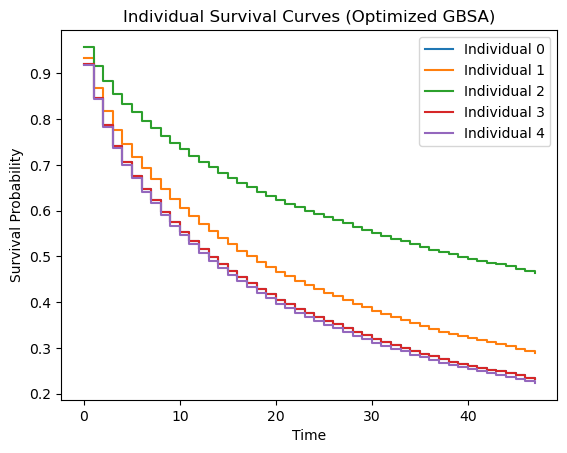

In [39]:
# Initialize the GradientBoostingSurvivalAnalysis with the best parameters
gbsa_best = GradientBoostingSurvivalAnalysis(learning_rate=best_params['learning_rate'],
                                             n_estimators=best_params['n_estimators'],
                                             min_samples_split=best_params['min_samples_split'],
                                             min_samples_leaf=best_params['min_samples_leaf'],
                                             random_state=42)

# Train the final model
gbsa_best.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Predict survival functions for the test set
test_surv_curves_best = gbsa_best.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_gbsa(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_gbsa_best = mean_survival_time_gbsa(test_surv_curves_best)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_best = pd.DataFrame(predicted_means_gbsa_best, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_gbsa_best = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_best.reset_index(drop=True)], axis=1)
print(results_gbsa_best[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_gbsa_best = mean_squared_error(results_gbsa_best['Survival months'], results_gbsa_best['Predicted Survival Time (Mean)'])
rmse_mean_gbsa_best = np.sqrt(mse_mean_gbsa_best)
print("Root Mean Squared Error (RMSE) with Optimized Gradient Boosting Survival Analysis Mean Prediction:", rmse_mean_gbsa_best)

# Calculate RRMSE
mean_observed = np.mean(results_gbsa_best['Survival months'])
rrmse_mean = rmse_mean_gbsa_best / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbsa_best['Survival months'], results_gbsa_best['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
c_index = gbsa_best.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves_best))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves_best[i].x, test_surv_curves_best[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Optimized GBSA)')
plt.legend()
plt.show()

### 4. SurvivalTree

In [83]:
%%time
from sksurv.tree import SurvivalTree

# Prepare feature matrices
X_train = train_data_new.drop(['Vital status', 'Survival months'], axis=1)
X_test = test_data_new.drop(['Vital status', 'Survival months'], axis=1)

# Initialize and train the SurvivalTree model
tree = SurvivalTree(random_state=42)
tree.fit(X_train, y_train_structured)


CPU times: total: 1.22 s
Wall time: 2.12 s


SurvivalTree(random_state=42)

SurvivalTree Results:
        Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       47.000000
1                    2             1                       38.750000
2                   31             1                       47.000000
3                    6             0                       37.600000
4                    4             1                       26.700000
...                ...           ...                             ...
10433               12             1                       34.900000
10434               28             1                       16.500000
10435               41             0                        0.166667
10436               10             1                       19.833333
10437                1             1                        0.750000

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction: 16.95649098529911
Root Relative Mean Squared Error (RRMSE

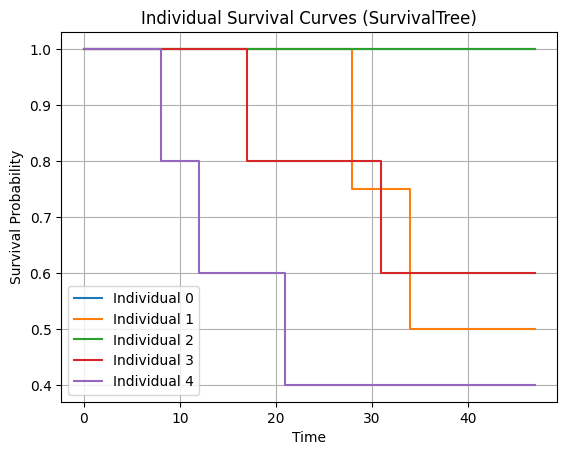

In [115]:
# Predict survival functions for the test set
test_surv_curves = tree.predict_survival_function(X_test)

# Function to calculate mean survival time
def mean_survival_time(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Calculate mean survival time for SurvivalTree
predicted_means_tree = mean_survival_time(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_tree = pd.DataFrame(predicted_means_tree, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_tree = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_tree.reset_index(drop=True)], axis=1)

# Print results
print("SurvivalTree Results:\n", results_tree[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_tree = mean_squared_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
rmse_mean_tree = np.sqrt(mse_mean_tree)
print("Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction:", rmse_mean_tree)

# Calculate RRMSE
mean_observed = np.mean(results_tree['Survival months'])
rrmse_mean = rmse_mean_tree / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = tree.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)


# Visualize the survival curves for the first 5 individuals
for i in range(min(5, len(test_surv_curves))):
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (SurvivalTree)')
plt.legend()
plt.grid(True)
plt.show()

#### Hyperparameter tuning

In [108]:
%%time

# Define the parameter grid for SurvivalTree
param_grid_st = {
    'min_samples_split': [5, 10, 15],  # Adjust the minimum number of samples required to split an internal node
    'min_samples_leaf': [5, 10, 15],  # Adjust the minimum number of samples required to be at a leaf node
    'max_features': [0.1, 0.5, 0.9],
    'max_depth': [5, 10, 15]
}

# Initialize SurvivalTree
st = SurvivalTree(random_state=42)

# Initialize GridSearchCV
grid_search_st = GridSearchCV(estimator=st, param_grid=param_grid_st, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search_st.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Print the best parameters
print("Best Parameters:", grid_search_st.best_params_)

# Extract the best parameters
best_params_st = grid_search_st.best_params_

Best Parameters: {'max_depth': 5, 'max_features': 0.1, 'min_samples_leaf': 5, 'min_samples_split': 5}
CPU times: total: 1.89 s
Wall time: 43.6 s


c:\Users\小敏\.conda\envs\PY37\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       23.278372
1                    2             1                       24.192594
2                   31             1                       41.507158
3                    6             0                       19.214259
4                    4             1                       14.772510
...                ...           ...                             ...
10433               12             1                       17.288499
10434               28             1                       33.598274
10435               41             0                        6.146255
10436               10             1                       19.214259
10437                1             1                        6.146255

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Optimized SurvivalTree Mean Prediction: 13.278206857319141
Root Relative Mean Squared Error (RRMSE) with Optim

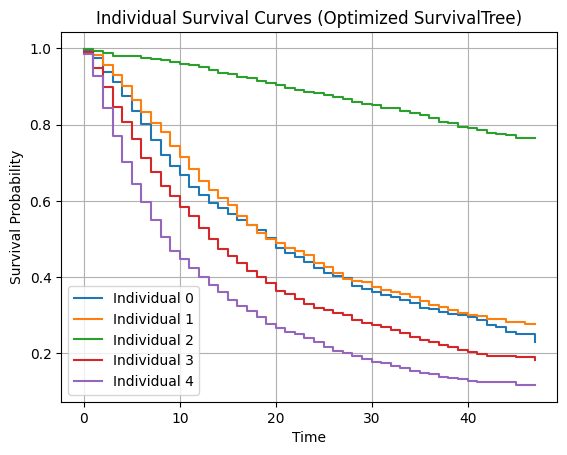

In [116]:
# Initialize the SurvivalTree with the best parameters
st_best = SurvivalTree(min_samples_split=best_params_st['min_samples_split'],
                       min_samples_leaf=best_params_st['min_samples_leaf'],
                       max_depth=best_params_st['max_depth'],
                       random_state=42)

# Train the final model
st_best.fit(train_data_new.drop(['Vital status', 'Survival months'], axis=1), y_train_structured)

# Convert test data
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

# Predict survival functions for the test set
test_surv_curves_best_st = st_best.predict_survival_function(test_data_new.drop(['Vital status', 'Survival months'], axis=1), return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_st(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_st_best = mean_survival_time_st(test_surv_curves_best_st)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_st_best = pd.DataFrame(predicted_means_st_best, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_st_best = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df_st_best.reset_index(drop=True)], axis=1)
print(results_st_best[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_st_best = mean_squared_error(results_st_best['Survival months'], results_st_best['Predicted Survival Time (Mean)'])
rmse_mean_st_best = np.sqrt(mse_mean_st_best)
print("Root Mean Squared Error (RMSE) with Optimized SurvivalTree Mean Prediction:", rmse_mean_st_best)

# Calculate RRMSE
mean_observed = np.mean(results_st_best['Survival months'])
rrmse_mean = rmse_mean_st_best / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Optimized SurvivalTree Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_st_best['Survival months'], results_st_best['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Optimized SurvivalTree Mean Prediction:", mae_mean)

# Calculate C-index
c_index = st_best.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves_best_st))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves_best_st[i].x, test_surv_curves_best_st[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Optimized SurvivalTree)')
plt.legend()
plt.grid(True)
plt.show()


### 5. Stacking

In [31]:
%%time
from sksurv.meta import Stacking

# Function to convert DataFrame to structured array for scikit-survival
def df_to_structured(df, event_col, time_col):
    return np.array([(e, t) for e, t in zip(df[event_col], df[time_col])], dtype=[('event', bool), ('time', np.float64)])

# Calculate mean survival time from survival functions
def mean_survival_time(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Reset indices to ensure consistency
x_train_df = x_train_df.reset_index(drop=True)
x_test_df = x_test_df.reset_index(drop=True)
y_surv_train = y_surv_train.reset_index(drop=True)
y_surv_test = y_surv_test.reset_index(drop=True)
y_vital_train = y_vital_train.reset_index(drop=True)
y_vital_test = y_vital_test.reset_index(drop=True)

# Convert training and testing data
y_train_structured = df_to_structured(train_data_new, 'Vital status', 'Survival months')
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

CPU times: total: 0 ns
Wall time: 34.4 ms


In [32]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.meta import Stacking

# Initialize base models
rsf = RandomSurvivalForest(random_state=42)
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
st = SurvivalTree(random_state=42)

# Initialize meta-model (Cox Proportional Hazards model)
meta_model = CoxPHSurvivalAnalysis()

# Initialize Stacking model
stacking_model = Stacking(
    meta_estimator=meta_model,
    base_estimators=[
        ("rsf", rsf),
        ("gbsa", gbsa),
        ("st", st)
    ],
    probabilities=False  # Set to False if base models do not support predict_proba
)

# Train the stacking model
stacking_model.fit(x_train_df, y_train_structured)

Stacking(base_estimators=[('rsf', RandomSurvivalForest(random_state=42)),
                          ('gbsa',
                           GradientBoostingSurvivalAnalysis(random_state=42)),
                          ('st', SurvivalTree(random_state=42))],
         meta_estimator=CoxPHSurvivalAnalysis(), probabilities=False)

       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       38.038925
1                    2             1                       33.649640
2                   31             1                       41.150708
3                    6             0                       28.782748
4                    4             1                       28.635611
...                ...           ...                             ...
10433               12             1                       34.201928
10434               28             1                       24.602778
10435               41             0                        3.512792
10436               10             1                       20.043884
10437                1             1                        2.542660

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 15.028164045595384
Root Relative Mean Squared Error (RRMSE) with Mean 

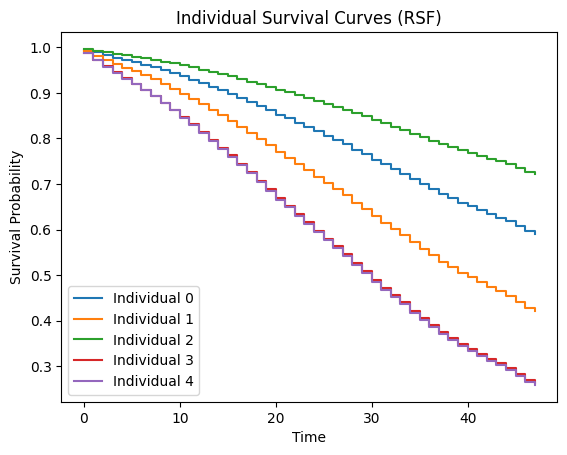

In [38]:
# Predict survival functions for the test set
test_surv_curves = stacking_model.predict_survival_function(x_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_sta(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_sta = mean_survival_time_sta(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_sta, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_sta = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_sta[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_sta = mean_squared_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
rmse_mean_sta = np.sqrt(mse_mean_sta)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_sta)

# Calculate RRMSE
mean_observed = np.mean(results_sta['Survival months'])
rrmse_mean = rmse_mean_sta / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = stacking_model.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.show()

In [50]:
%%time
from sksurv.meta import Stacking

# Function to convert DataFrame to structured array for scikit-survival
def df_to_structured(df, event_col, time_col):
    return np.array([(e, t) for e, t in zip(df[event_col], df[time_col])], dtype=[('event', bool), ('time', np.float64)])

# Calculate mean survival time from survival functions
def mean_survival_time(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Reset indices to ensure consistency
x_train_df = x_train_df.reset_index(drop=True)
x_test_df = x_test_df.reset_index(drop=True)
y_surv_train = y_surv_train.reset_index(drop=True)
y_surv_test = y_surv_test.reset_index(drop=True)
y_vital_train = y_vital_train.reset_index(drop=True)
y_vital_test = y_vital_test.reset_index(drop=True)

# Convert training and testing data
y_train_structured = df_to_structured(train_data_new, 'Vital status', 'Survival months')
y_test_structured = df_to_structured(test_data_new, 'Vital status', 'Survival months')

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.meta import Stacking

# Initialize base models
rsf = RandomSurvivalForest(min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42)
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
st = SurvivalTree(max_depth=5, max_features=0.1, min_samples_leaf=5, min_samples_split=5, random_state=42)

# Initialize meta-model (Cox Proportional Hazards model)
meta_model = CoxPHSurvivalAnalysis(alpha=1250)

# Initialize Stacking model
stacking_model = Stacking(
    meta_estimator=meta_model,
    base_estimators=[
        ("rsf", rsf),
        ("gbsa", gbsa),
        ("st", st)
    ],
    probabilities=False  # Set to False if base models do not support predict_proba
)

# Train the stacking model
stacking_model.fit(x_train_df, y_train_structured)

CPU times: total: 7min 34s
Wall time: 7min 34s


Stacking(base_estimators=[('rsf',
                           RandomSurvivalForest(min_samples_leaf=5,
                                                min_samples_split=10,
                                                n_estimators=50,
                                                random_state=42)),
                          ('gbsa',
                           GradientBoostingSurvivalAnalysis(random_state=42)),
                          ('st',
                           SurvivalTree(max_depth=5, max_features=0.1,
                                        min_samples_leaf=5, min_samples_split=5,
                                        random_state=42))],
         meta_estimator=CoxPHSurvivalAnalysis(alpha=1250), probabilities=False)

       Survival months  Vital status  Predicted Survival Time (Mean)
0                   19             1                       22.074017
1                    2             1                       24.565485
2                   31             1                       36.823654
3                    6             0                       15.950588
4                    4             1                       23.539036
...                ...           ...                             ...
10433               12             1                       20.669460
10434               28             1                       32.649348
10435               41             0                        5.133750
10436               10             1                       23.894694
10437                1             1                        3.490386

[10438 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 13.278592606678764
Root Relative Mean Squared Error (RRMSE) with Mean 

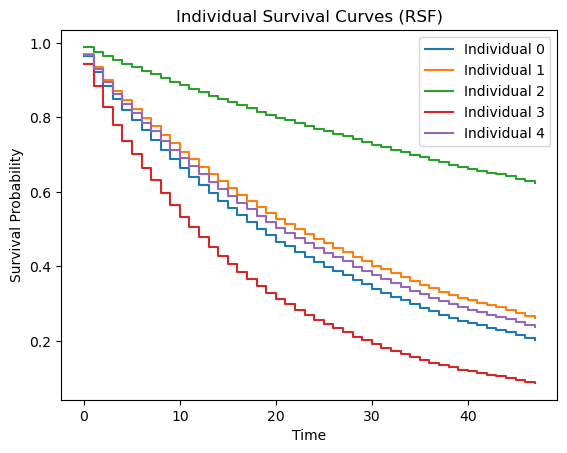

In [51]:
# Predict survival functions for the test set
test_surv_curves = stacking_model.predict_survival_function(x_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_sta(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_sta = mean_survival_time_sta(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_sta, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_sta = pd.concat([test_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_sta[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_sta = mean_squared_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
rmse_mean_sta = np.sqrt(mse_mean_sta)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_sta)

# Calculate RRMSE
mean_observed = np.mean(results_sta['Survival months'])
rrmse_mean = rmse_mean_sta / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = stacking_model.score(test_data_new.drop(['Vital status', 'Survival months'], axis=1), y_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.show()

### 6. Deepsurv

In [ ]:
from deepsurvk import DeepSurvK, common_callbacks

In [42]:
Y_train = np.array(y_surv_train, dtype=np.int32)
Y_test  = np.array(y_surv_test, dtype=np.int32)

In [59]:
X_train = train_data_new.drop(['Vital status', 'Survival months'], axis=1)
X_test= test_data_new.drop(['Vital status', 'Survival months'], axis=1)
E_train = np.where(y_vital_train == 'Dead', 1, 0)
E_test = np.where(y_vital_test == 'Dead', 1, 0)

In [45]:
X_train

,Age,Median household income,Grade,Combined Summary Stage,Stage Group,Tumor Size,Sex_Female,Sex_Male,Race_American Indian/Alaska Native,Race_Asian or Pacific Islander,...,Chemotherapy_No,Chemotherapy_Yes,Mets at DX-bone_No,Mets at DX-bone_Yes,Mets at DX-brain_No,Mets at DX-brain_Yes,Mets at DX-lung_No,Mets at DX-lung_Yes,Mets at DX-liver_No,Mets at DX-liver_Yes
0,-0.287580,6,1,2,3,-0.182046,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.208346,7,1,0,0,-1.036538,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.985679,6,2,2,3,0.636842,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.507531,4,1,2,3,-0.644896,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,-0.786222,6,1,1,1,-0.858519,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24349,1.308074,6,0,0,0,-0.965331,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
24350,0.111333,2,1,1,0,-0.253254,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
24351,1.008889,8,1,2,3,0.115958,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
24352,-0.586765,5,2,2,3,-0.324462,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [47]:
# Sorting
sort_idx = np.argsort(Y_train)[::-1]
X_train = X_train.values[sort_idx]
Y_train = Y_train[sort_idx]
E_train = E_train[sort_idx]

In [48]:
n_patients_train = X_train.shape[0]
n_features = X_train.shape[1]

In [49]:
%%time

# Create a DeepSurvK model
dsk = DeepSurvK(n_features=n_features, E=E_train)
dsk.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (Dense)           (None, 32)                1056      
_________________________________________________________________
DroputInput (Dropout)        (None, 32)                0         
_________________________________________________________________
HiddenLayer1 (Dense)         (None, 25)                825       
_________________________________________________________________
Dropout1 (Dropout)           (None, 25)                0         
_________________________________________________________________
HiddenLayer2 (Dense)         (None, 25)                650       
_________________________________________________________________
Dropout2 (Dropout)           (None, 25)                0         
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 2

In [50]:
# Define callbacks
callbacks = deepsurvk.common_callbacks()
print(callbacks)

[<tensorflow.python.keras.callbacks.TerminateOnNaN object at 0x0000017128E19D30>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x0000017128DD1C10>]


In [51]:
# Model fitting
epochs = 1000
history = dsk.fit(X_train, Y_train,
                  batch_size=n_patients_train,
                  epochs=epochs,
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/1000
1/1 [==============================] - 39s 39s/step - loss: 3670272000.0000
Epoch 2/1000
1/1 [==============================] - 2s 2s/step - loss: 3620860672.0000
Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 3589483008.0000
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 3563671552.0000
Epoch 5/1000
1/1 [==============================] - 3s 3s/step - loss: 3538919936.0000
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 3522177792.0000
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 3503184128.0000
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 3500080640.0000
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 3497995520.0000
Epoch 10/1000
1/1 [==============================] - 2s 2s/step - loss: 3486724096.0000
Epoch 11/1000
1/1 [==============================] - 2s 2s/step - loss: 3481682944.0000
Epoch 12/1000
1/1 [====================

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:xlabel='No. epochs', ylabel='Loss [u.a.]'>)

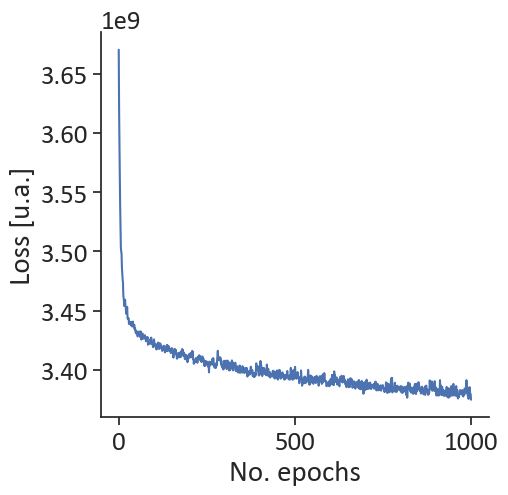

In [54]:
# Plot training loss
deepsurvk.plot_loss(history)

In [207]:
# Model predictions
Y_pred_train = np.exp(-dsk.predict(X_train))
c_index_train = concordance_index(Y_train, Y_pred_train, E_train)
print(f"c-index of training dataset = {c_index_train}")

Y_pred_test = np.exp(-dsk.predict(X_test))
c_index_test = deepsurvk.concordance_index(Y_test, Y_pred_test, E_test)
print(f"c-index of testing dataset = {c_index_test}")

c-index of training dataset = 0.6250946713346228
c-index of testing dataset = 0.7722934191159387


In [61]:
# Calculate mean survival time for each individual in the test set
def mean_survival_time_deepsurvk(pred_surv_funcs):
    mean_times = []
    for surv_func in pred_surv_funcs:
        times = surv_func[:, 0]
        survival_probs = surv_func[:, 1]
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Predict survival functions for the test set
test_surv_funcs = dsk.predict_survival_function(test_data_new1)
predicted_means_deepsurvk = mean_survival_time_deepsurvk(test_surv_funcs)


AttributeError: 'Sequential' object has no attribute 'predict_survival_function'

In [ ]:
# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_deepsurvk, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_deepsurvk = pd.DataFrame({
    'Survival months': Y_test,
    'Vital status': E_test,
    'Predicted Survival Time (Mean)': predicted_means_deepsurvk
})
print(results_deepsurvk)

# Calculate RMSE for Mean Predictions
mse_mean_deepsurvk = mean_squared_error(results_deepsurvk['Survival months'], results_deepsurvk['Predicted Survival Time (Mean)'])
rmse_mean_deepsurvk = np.sqrt(mse_mean_deepsurvk)
print("Root Mean Squared Error (RMSE) with DeepSurvK Mean Prediction:", rmse_mean_deepsurvk)

# Visualize the survival curves
for i in range(min(5, len(test_surv_funcs))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_funcs[i][:, 0], test_surv_funcs[i][:, 1], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (DeepSurvK)')
plt.legend()
plt.show()

In [186]:
def negative_log_likelihood(E):
    def loss(y_true, y_pred):
        
        hazard_ratio = tf.math.exp(y_pred)        
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)

        # TODO
        # For some reason, adding num_observed_events does not work.
        # Therefore, for now we will use it as a simple factor of 1.
        # Is it really needed? Isn't it just a scaling factor?
        # num_observed_events = tf.math.cumsum(E)
        # num_observed_events = tf.cast(num_observed_events, dtype=tf.float32)
        num_observed_events = tf.constant(1, dtype=tf.float32)
        
        neg_likelihood = neg_likelihood_ / num_observed_events        
        
        return neg_likelihood
    
    return loss

In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

In [197]:
activation = 'relu'
n_nodes = 48
learning_rate = 0.067
l2_reg = 16.094
dropout = 0.147
lr_decay =  6.494e-4
momentum = 0.863

# Create model
model = Sequential()
model.add(Dense(units=n_features, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(ActivityRegularization(l2=l2_reg))

# Define the optimizer
# Nadam is Adam + Nesterov momentum
# optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay, clipnorm=1) 
optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay)

# Compile the model and show a summary of it
model.compile(loss=negative_log_likelihood(E_train), optimizer=optimizer)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 48)                1584      
_________________________________________________________________
dropout_10 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 48)                2352      
_________________________________________________________________
dropout_11 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [201]:
model